In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
import argparse
import os
from collections import OrderedDict
from glob import glob
import numpy as np
import cv2
%matplotlib inline

In [3]:
import pandas as pd
import torch
import torch.backends.cudnn as cudnn
import torch.nn as nn
import yaml
from tqdm import tqdm

In [4]:
from sklearn.model_selection import train_test_split

In [5]:
import archs
import losses
from dataset import Dataset, make_loader, Dataset_img_only, make_loader_test_only
from utils import AverageMeter, str2bool, scheduler_maker, optim_maker  
from train_val import train, val, test, val_sdr_stratified
import adabound 

In [6]:
ARCH_NAMES = archs.__all__
LOSS_NAMES = losses.__all__

In [7]:
def parse_args():
    parser = argparse.ArgumentParser()

    parser.add_argument('--name', default=None,
                        help='model name: (default: arch+timestamp)')
    parser.add_argument('--epochs', default=100, type=int, metavar='N',
                        help='number of total epochs to run')
    parser.add_argument('-b', '--batch_size', default=16, type=int,
                        metavar='N', help='mini-batch size (default: 16)')
    
    # model
    parser.add_argument('--arch', '-a', metavar='ARCH', default='UNet',
                        choices=ARCH_NAMES,
                        help='model architecture: ' +
                        ' | '.join(ARCH_NAMES) +
                        ' (default: UNet)')
    parser.add_argument('--input_channels', default=3, type=int,
                        help='input channels')
    parser.add_argument('--num_classes', default=1, type=int,
                        help='number of classes')
    parser.add_argument('--input_w', default=224, type=int,
                        help='image width')
    parser.add_argument('--input_h', default=224, type=int,
                        help='image height')
    
    # loss
    parser.add_argument('--loss', default='MseLoss',
                        choices=LOSS_NAMES,
                        help='loss: ' +
                        ' | '.join(LOSS_NAMES) +
                        ' (default: MseLoss)')
    
    # dataset
    parser.add_argument('--dataset', default='Likelymapseparate',
                        help='dataset name')
    parser.add_argument('--img_ext', default='.jpg',
                        help='image file extension')
    parser.add_argument('--mask_ext', default='.jpg',
                        help='mask file extension')

    # optimizer
    parser.add_argument('--optimizer', default='Adam',
                        choices=['Adam', 'SGD', 'Adabound'],
                        help='loss: ' +
                        ' | '.join(['Adam', 'SGD', 'Adabound']) +
                        ' (default: Adam)')
    parser.add_argument('--lr', '--learning_rate', default=1e-3, type=float,
                        metavar='LR', help='initial learning rate')
    parser.add_argument('--momentum', default=0.9, type=float,
                        help='momentum')
    parser.add_argument('--weight_decay', default=1e-4, type=float,
                        help='weight decay')
    parser.add_argument('--nesterov', default=False, type=str2bool,
                        help='nesterov')
    parser.add_argument('--val_ratio', default=0.3, type=float,
                        help='val_ratio')

    # scheduler
    parser.add_argument('--scheduler', default='CosineAnnealingLR',
                        choices=['CosineAnnealingLR', 'ReduceLROnPlateau', 'MultiStepLR', 'ConstantLR'])
    parser.add_argument('--min_lr', default=1e-6, type=float,
                        help='minimum learning rate')
    parser.add_argument('--factor', default=0.1, type=float)
    parser.add_argument('--patience', default=2, type=int)
    parser.add_argument('--milestones', default='1,2', type=str)
    parser.add_argument('--gamma', default=2/3, type=float)
    parser.add_argument('--early_stopping', default=-1, type=int,
                        metavar='N', help='early stopping (default: -1)')
    
    parser.add_argument('--num_workers', default=8, type=int)
    
    parser.add_argument('--img_path', default='', type=str)
    parser.add_argument('--best_model_val', default='sdr', type=str)

    config = parser.parse_args(args=['--best_model_val', 'sdr', '--arch', 'UNet', '--num_workers', '8', '--lr', '0.0001', '--epochs', '1000', '--optimizer', 'Adam', '--batch_size', '16', '--num_classes','15', '--dataset', '1381label_lilkely_num15_224_filt5', '--loss', 'MseLoss'])

    return config

In [8]:
def main():
    config = vars(parse_args())

    if config['name'] is None:
        config['name'] = '%s_%s_%s_%s_%s' % (config['dataset'], config['arch'], config['loss'], config['optimizer'], config['scheduler'])
    os.makedirs('models/%s' % config['name'], exist_ok=True)

    print('-' * 20)
    for key in config:
        print('%s: %s' % (key, config[key]))
    print('-' * 20)

    with open('models/%s/config.yml' % config['name'], 'w') as f:
        yaml.dump(config, f)

    criterion = losses.__dict__[config['loss']]().cuda()

    cudnn.benchmark = True

    print("=> creating model %s" % config['arch'])
    model = archs.__dict__[config['arch']](config['num_classes'],config['input_channels'])

    model = model.cuda()
    params = filter(lambda p: p.requires_grad, model.parameters())
    optimizer = optim_maker(params, config) 

    #create scheduler
    scheduler = scheduler_maker(optimizer, config)        

    # Data loading code
    img_ids = glob(os.path.join(config['img_path'] + config['dataset'] + "/"+ 'images' +"/"+ '*' + config['img_ext']))
    img_ids = [os.path.splitext(os.path.basename(p))[0] for p in img_ids]

    train_img_ids, val_img_ids = train_test_split(img_ids, test_size=config['val_ratio'], random_state=1)

    train_loader, val_loader = make_loader(train_img_ids, val_img_ids, config)

    log = OrderedDict([('epoch', []),('lr', []),('loss', []),('val_loss', []),('SDR', []),('R_ave', [])])
    
    best_R = 200
    trigger = 0
    for epoch in range(config['epochs']):
        print('Epoch [%d/%d]' % (epoch, config['epochs']))

        # train for one epoch
        train_log = train(config, train_loader, model, criterion, optimizer)
        val_log, best_R = val(config, val_loader, model, criterion, scheduler, log, train_log, best_R, trigger, epoch)

        torch.cuda.empty_cache()

if __name__ == '__main__':
    main()

--------------------
name: 1381label_lilkely_num15_224_filt5_UNet_MseLoss_Adam_CosineAnnealingLR
epochs: 1000
batch_size: 16
arch: UNet
input_channels: 3
num_classes: 15
input_w: 224
input_h: 224
loss: MseLoss
dataset: 1381label_lilkely_num15_224_filt5
img_ext: .jpg
mask_ext: .jpg
optimizer: Adam
lr: 0.0001
momentum: 0.9
weight_decay: 0.0001
nesterov: False
val_ratio: 0.3
scheduler: CosineAnnealingLR
min_lr: 1e-06
factor: 0.1
patience: 2
milestones: 1,2
gamma: 0.6666666666666666
early_stopping: -1
num_workers: 8
img_path: D:\SHS_AI/nested_U/
best_model_val: sdr
--------------------
=> creating model UNet


C:\Users\hs691\anaconda3\envs\pytorch17\lib\site-packages\albumentations\augmentations\transforms.py:1772: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  FutureWarning,
  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [0/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0046 - val_loss 0.0022 - SDR 0.0013 - R_ave 118.2213
=> saved best model
Epoch [1/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0018 - val_loss 0.0016 - SDR 0.0076 - R_ave 83.0246
=> saved best model
Epoch [2/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0015 - val_loss 0.0015 - SDR 0.0299 - R_ave 61.5616
=> saved best model
Epoch [3/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0015 - val_loss 0.0015 - SDR 0.1086 - R_ave 37.8457
=> saved best model
Epoch [4/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0014 - val_loss 0.0014 - SDR 0.1729 - R_ave 31.4532
=> saved best model
Epoch [5/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0014 - val_loss 0.0014 - SDR 0.2567 - R_ave 23.7872
=> saved best model
Epoch [6/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0013 - val_loss 0.0013 - SDR 0.2726 - R_ave 24.0621
Epoch [7/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0012 - val_loss 0.0012 - SDR 0.3518 - R_ave 19.1709
=> saved best model
Epoch [8/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0011 - val_loss 0.0012 - SDR 0.3714 - R_ave 20.1880
Epoch [9/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0010 - val_loss 0.0012 - SDR 0.4145 - R_ave 22.0016
Epoch [10/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0009 - val_loss 0.0012 - SDR 0.4980 - R_ave 17.2903
=> saved best model
Epoch [11/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0008 - val_loss 0.0011 - SDR 0.5325 - R_ave 17.3028
Epoch [12/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0007 - val_loss 0.0008 - SDR 0.6649 - R_ave 7.1278
=> saved best model
Epoch [13/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0006 - val_loss 0.0008 - SDR 0.6932 - R_ave 6.5100
=> saved best model
Epoch [14/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0005 - val_loss 0.0007 - SDR 0.7409 - R_ave 5.3191
=> saved best model
Epoch [15/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0005 - val_loss 0.0008 - SDR 0.6914 - R_ave 7.3685
Epoch [16/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0004 - val_loss 0.0006 - SDR 0.7838 - R_ave 4.9712
=> saved best model
Epoch [17/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0004 - val_loss 0.0005 - SDR 0.8524 - R_ave 3.4839
=> saved best model
Epoch [18/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0003 - val_loss 0.0006 - SDR 0.8087 - R_ave 4.3234
Epoch [19/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0003 - val_loss 0.0004 - SDR 0.8773 - R_ave 2.8066
=> saved best model
Epoch [20/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0003 - val_loss 0.0004 - SDR 0.8684 - R_ave 2.7848
=> saved best model
Epoch [21/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0002 - val_loss 0.0003 - SDR 0.8877 - R_ave 2.6479
=> saved best model
Epoch [22/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0002 - val_loss 0.0003 - SDR 0.8957 - R_ave 2.4202
=> saved best model
Epoch [23/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0002 - val_loss 0.0003 - SDR 0.9094 - R_ave 2.3834
=> saved best model
Epoch [24/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0002 - val_loss 0.0003 - SDR 0.9158 - R_ave 2.1368
=> saved best model
Epoch [25/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0002 - val_loss 0.0003 - SDR 0.8967 - R_ave 2.5199
Epoch [26/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0002 - val_loss 0.0002 - SDR 0.9136 - R_ave 2.0610
=> saved best model
Epoch [27/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0002 - val_loss 0.0002 - SDR 0.9063 - R_ave 2.3128
Epoch [28/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0002 - val_loss 0.0004 - SDR 0.8920 - R_ave 3.3643
Epoch [29/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0002 - val_loss 0.0002 - SDR 0.9211 - R_ave 2.0468
=> saved best model
Epoch [30/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0002 - val_loss 0.0002 - SDR 0.9134 - R_ave 2.1834
Epoch [31/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0002 - val_loss 0.0002 - SDR 0.9187 - R_ave 2.1107
Epoch [32/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0002 - val_loss 0.0002 - SDR 0.9322 - R_ave 2.0048
=> saved best model
Epoch [33/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0002 - val_loss 0.0002 - SDR 0.9356 - R_ave 2.0528
Epoch [34/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0002 - val_loss 0.0002 - SDR 0.9243 - R_ave 2.0823
Epoch [35/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0002 - val_loss 0.0002 - SDR 0.9234 - R_ave 1.9507
=> saved best model
Epoch [36/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0002 - val_loss 0.0002 - SDR 0.9219 - R_ave 2.2105
Epoch [37/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0002 - val_loss 0.0002 - SDR 0.9369 - R_ave 1.8164
=> saved best model
Epoch [38/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0002 - val_loss 0.0002 - SDR 0.9324 - R_ave 1.9279
Epoch [39/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0002 - val_loss 0.0002 - SDR 0.9417 - R_ave 1.8974
Epoch [40/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0002 - val_loss 0.0002 - SDR 0.9404 - R_ave 1.7436
=> saved best model
Epoch [41/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0002 - val_loss 0.0002 - SDR 0.9394 - R_ave 1.8630
Epoch [42/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0002 - val_loss 0.0001 - SDR 0.9486 - R_ave 1.6256
=> saved best model
Epoch [43/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0002 - val_loss 0.0002 - SDR 0.9383 - R_ave 1.7736
Epoch [44/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0002 - val_loss 0.0002 - SDR 0.9412 - R_ave 1.7776
Epoch [45/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0002 - val_loss 0.0002 - SDR 0.9499 - R_ave 1.7381
Epoch [46/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0002 - val_loss 0.0002 - SDR 0.9340 - R_ave 1.9106
Epoch [47/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0002 - val_loss 0.0001 - SDR 0.9515 - R_ave 1.6342
Epoch [48/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0002 - val_loss 0.0001 - SDR 0.9508 - R_ave 1.6639
Epoch [49/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0002 - val_loss 0.0002 - SDR 0.9512 - R_ave 1.6647
Epoch [50/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0002 - val_loss 0.0002 - SDR 0.9406 - R_ave 1.7132
Epoch [51/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0002 - val_loss 0.0001 - SDR 0.9536 - R_ave 1.5475
=> saved best model
Epoch [52/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0002 - val_loss 0.0002 - SDR 0.9418 - R_ave 2.1388
Epoch [53/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0002 - val_loss 0.0002 - SDR 0.9449 - R_ave 1.7342
Epoch [54/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0002 - val_loss 0.0001 - SDR 0.9531 - R_ave 1.5644
Epoch [55/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9488 - R_ave 1.7056
Epoch [56/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0002 - val_loss 0.0002 - SDR 0.9446 - R_ave 1.7363
Epoch [57/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0002 - val_loss 0.0002 - SDR 0.9415 - R_ave 1.9092
Epoch [58/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0002 - val_loss 0.0001 - SDR 0.9513 - R_ave 1.5937
Epoch [59/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0002 - val_loss 0.0002 - SDR 0.9494 - R_ave 1.7179
Epoch [60/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0002 - val_loss 0.0002 - SDR 0.9412 - R_ave 1.8930
Epoch [61/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0002 - val_loss 0.0001 - SDR 0.9516 - R_ave 1.6561
Epoch [62/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9566 - R_ave 1.5487
Epoch [63/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0002 - SDR 0.9462 - R_ave 1.6936
Epoch [64/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0002 - val_loss 0.0001 - SDR 0.9545 - R_ave 1.6031
Epoch [65/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9555 - R_ave 1.5825
Epoch [66/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9602 - R_ave 1.4990
=> saved best model
Epoch [67/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9515 - R_ave 1.6160
Epoch [68/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9528 - R_ave 1.5973
Epoch [69/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9547 - R_ave 1.5747
Epoch [70/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9561 - R_ave 1.6787
Epoch [71/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9521 - R_ave 1.6829
Epoch [72/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9576 - R_ave 1.5338
Epoch [73/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9582 - R_ave 1.5261
Epoch [74/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0002 - SDR 0.9520 - R_ave 1.6804
Epoch [75/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9516 - R_ave 1.6046
Epoch [76/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9602 - R_ave 1.5385
Epoch [77/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9557 - R_ave 1.5851
Epoch [78/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0002 - SDR 0.9510 - R_ave 1.7995
Epoch [79/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9614 - R_ave 1.5112
Epoch [80/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0002 - SDR 0.9557 - R_ave 1.6874
Epoch [81/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9566 - R_ave 1.6262
Epoch [82/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9590 - R_ave 1.5483
Epoch [83/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0002 - SDR 0.9473 - R_ave 1.7996
Epoch [84/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0002 - val_loss 0.0001 - SDR 0.9545 - R_ave 1.6994
Epoch [85/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9560 - R_ave 1.5763
Epoch [86/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9536 - R_ave 1.6246
Epoch [87/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9563 - R_ave 1.5568
Epoch [88/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9589 - R_ave 1.5733
Epoch [89/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9622 - R_ave 1.4939
=> saved best model
Epoch [90/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0002 - SDR 0.9367 - R_ave 2.1366
Epoch [91/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9603 - R_ave 1.5496
Epoch [92/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9563 - R_ave 1.5495
Epoch [93/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9573 - R_ave 1.5840
Epoch [94/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9586 - R_ave 1.5955
Epoch [95/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9643 - R_ave 1.5477
Epoch [96/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9595 - R_ave 1.5175
Epoch [97/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0002 - SDR 0.9504 - R_ave 1.7830
Epoch [98/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9592 - R_ave 1.5809
Epoch [99/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9635 - R_ave 1.5005
Epoch [100/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9589 - R_ave 1.5948
Epoch [101/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9565 - R_ave 1.6189
Epoch [102/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9590 - R_ave 1.6069
Epoch [103/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0002 - SDR 0.9587 - R_ave 1.5744
Epoch [104/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0002 - SDR 0.9510 - R_ave 1.6933
Epoch [105/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0002 - SDR 0.9563 - R_ave 1.5973
Epoch [106/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9603 - R_ave 1.4995
Epoch [107/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9592 - R_ave 1.5682
Epoch [108/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9550 - R_ave 1.5695
Epoch [109/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0002 - SDR 0.9537 - R_ave 1.6534
Epoch [110/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9549 - R_ave 1.6606
Epoch [111/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9500 - R_ave 1.6792
Epoch [112/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9600 - R_ave 1.5227
Epoch [113/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0002 - SDR 0.9563 - R_ave 1.6859
Epoch [114/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9605 - R_ave 1.5747
Epoch [115/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9650 - R_ave 1.5386
Epoch [116/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0002 - SDR 0.9529 - R_ave 1.7278
Epoch [117/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9547 - R_ave 1.5885
Epoch [118/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9594 - R_ave 1.5352
Epoch [119/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9597 - R_ave 1.6003
Epoch [120/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9621 - R_ave 1.6191
Epoch [121/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9594 - R_ave 1.5261
Epoch [122/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9590 - R_ave 1.5552
Epoch [123/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9631 - R_ave 1.4653
=> saved best model
Epoch [124/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9549 - R_ave 1.6362
Epoch [125/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9558 - R_ave 1.6098
Epoch [126/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0002 - SDR 0.9524 - R_ave 1.6282
Epoch [127/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0002 - SDR 0.9536 - R_ave 1.6807
Epoch [128/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9598 - R_ave 1.5377
Epoch [129/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9574 - R_ave 1.5078
Epoch [130/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9582 - R_ave 1.5778
Epoch [131/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9634 - R_ave 1.5145
Epoch [132/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9582 - R_ave 1.5707
Epoch [133/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0002 - SDR 0.9545 - R_ave 1.5784
Epoch [134/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9568 - R_ave 1.6182
Epoch [135/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9600 - R_ave 1.4777
Epoch [136/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9557 - R_ave 1.6009
Epoch [137/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0002 - SDR 0.9391 - R_ave 1.6650
Epoch [138/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0002 - SDR 0.9533 - R_ave 1.7085
Epoch [139/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9561 - R_ave 1.5802
Epoch [140/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9539 - R_ave 1.6555
Epoch [141/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9603 - R_ave 1.5244
Epoch [142/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0002 - SDR 0.9513 - R_ave 1.6644
Epoch [143/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9566 - R_ave 1.5400
Epoch [144/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0002 - SDR 0.9576 - R_ave 1.6248
Epoch [145/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9555 - R_ave 1.6278
Epoch [146/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9581 - R_ave 1.5087
Epoch [147/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9576 - R_ave 1.6505
Epoch [148/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9576 - R_ave 1.5967
Epoch [149/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9650 - R_ave 1.4962
Epoch [150/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9565 - R_ave 1.6510
Epoch [151/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9611 - R_ave 1.4881
Epoch [152/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9573 - R_ave 1.5654
Epoch [153/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9650 - R_ave 1.4626
=> saved best model
Epoch [154/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9648 - R_ave 1.5056
Epoch [155/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9618 - R_ave 1.4728
Epoch [156/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0002 - SDR 0.9528 - R_ave 1.6361
Epoch [157/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0002 - SDR 0.9541 - R_ave 1.8470
Epoch [158/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0002 - SDR 0.9550 - R_ave 1.6981
Epoch [159/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9619 - R_ave 1.5612
Epoch [160/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0002 - SDR 0.9526 - R_ave 1.7535
Epoch [161/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9569 - R_ave 1.5390
Epoch [162/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9565 - R_ave 1.6355
Epoch [163/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9600 - R_ave 1.5097
Epoch [164/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0002 - SDR 0.9502 - R_ave 1.7037
Epoch [165/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0003 - SDR 0.9497 - R_ave 1.8229
Epoch [166/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9627 - R_ave 1.5410
Epoch [167/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0002 - SDR 0.9454 - R_ave 1.7589
Epoch [168/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9639 - R_ave 1.4542
=> saved best model
Epoch [169/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9552 - R_ave 1.5827
Epoch [170/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0002 - SDR 0.9427 - R_ave 2.1051
Epoch [171/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9603 - R_ave 1.4699
Epoch [172/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9605 - R_ave 1.5539
Epoch [173/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9611 - R_ave 1.5870
Epoch [174/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9534 - R_ave 1.6448
Epoch [175/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0002 - SDR 0.9571 - R_ave 1.7594
Epoch [176/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9602 - R_ave 1.4932
Epoch [177/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9597 - R_ave 1.5587
Epoch [178/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9624 - R_ave 1.5724
Epoch [179/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9578 - R_ave 1.5760
Epoch [180/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9608 - R_ave 1.6137
Epoch [181/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9558 - R_ave 1.7319
Epoch [182/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9613 - R_ave 1.5040
Epoch [183/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9587 - R_ave 1.5631
Epoch [184/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9626 - R_ave 1.5523
Epoch [185/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9536 - R_ave 1.7066
Epoch [186/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9621 - R_ave 1.5006
Epoch [187/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9643 - R_ave 1.5122
Epoch [188/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9613 - R_ave 1.4918
Epoch [189/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9550 - R_ave 1.5522
Epoch [190/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9592 - R_ave 1.6221
Epoch [191/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9626 - R_ave 1.5702
Epoch [192/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9598 - R_ave 1.5807
Epoch [193/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9600 - R_ave 1.5883
Epoch [194/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0002 - SDR 0.9459 - R_ave 2.0776
Epoch [195/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9624 - R_ave 1.5163
Epoch [196/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9549 - R_ave 1.7761
Epoch [197/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9655 - R_ave 1.4500
=> saved best model
Epoch [198/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9592 - R_ave 1.5748
Epoch [199/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9595 - R_ave 1.5073
Epoch [200/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9574 - R_ave 1.5521
Epoch [201/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9664 - R_ave 1.4651
Epoch [202/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0003 - SDR 0.8842 - R_ave 4.1304
Epoch [203/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9582 - R_ave 1.4851
Epoch [204/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9534 - R_ave 1.7512
Epoch [205/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9608 - R_ave 1.5150
Epoch [206/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9627 - R_ave 1.4716
Epoch [207/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9579 - R_ave 1.6412
Epoch [208/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0002 - SDR 0.9447 - R_ave 1.7344
Epoch [209/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9549 - R_ave 1.6176
Epoch [210/1000]


100%|██████████| 26/26 [00:17<00:00,  1.52it/s, val_loss=0.00011, SDR=0.962, R_ave=1.49] 


loss 0.0001 - val_loss 0.0001 - SDR 0.9618 - R_ave 1.4874


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [211/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9618 - R_ave 1.4909
Epoch [212/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9566 - R_ave 1.5890
Epoch [213/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9614 - R_ave 1.4821
Epoch [214/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9603 - R_ave 1.5172
Epoch [215/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9610 - R_ave 1.4779
Epoch [216/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9613 - R_ave 1.5191
Epoch [217/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9553 - R_ave 1.5993
Epoch [218/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9614 - R_ave 1.4567
Epoch [219/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9637 - R_ave 1.4758
Epoch [220/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9656 - R_ave 1.4373
=> saved best model
Epoch [221/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9666 - R_ave 1.4423
Epoch [222/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9576 - R_ave 1.5249
Epoch [223/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9611 - R_ave 1.4817
Epoch [224/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9557 - R_ave 1.5895
Epoch [225/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9645 - R_ave 1.4683
Epoch [226/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0002 - SDR 0.9539 - R_ave 1.9784
Epoch [227/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9635 - R_ave 1.5122
Epoch [228/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9605 - R_ave 1.5322
Epoch [229/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9566 - R_ave 1.5984
Epoch [230/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9653 - R_ave 1.4052
=> saved best model
Epoch [231/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9582 - R_ave 1.5329
Epoch [232/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9542 - R_ave 1.5207
Epoch [233/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9624 - R_ave 1.4726
Epoch [234/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0002 - SDR 0.9518 - R_ave 1.7638
Epoch [235/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9496 - R_ave 1.5949
Epoch [236/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9587 - R_ave 1.5515
Epoch [237/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0003 - SDR 0.9115 - R_ave 2.5029
Epoch [238/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9542 - R_ave 1.6814
Epoch [239/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9605 - R_ave 1.4664
Epoch [240/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9645 - R_ave 1.4554
Epoch [241/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9627 - R_ave 1.4822
Epoch [242/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9582 - R_ave 1.5238
Epoch [243/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0002 - SDR 0.9308 - R_ave 2.2362
Epoch [244/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9571 - R_ave 1.5047
Epoch [245/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9579 - R_ave 1.5714
Epoch [246/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9533 - R_ave 1.5959
Epoch [247/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9626 - R_ave 1.5521
Epoch [248/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9600 - R_ave 1.5205
Epoch [249/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9650 - R_ave 1.4614
Epoch [250/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0002 - SDR 0.9409 - R_ave 1.9096
Epoch [251/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9639 - R_ave 1.4415
Epoch [252/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9578 - R_ave 1.5885
Epoch [253/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9512 - R_ave 1.6378
Epoch [254/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9621 - R_ave 1.4568
Epoch [255/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9618 - R_ave 1.5532
Epoch [256/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9621 - R_ave 1.5355
Epoch [257/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9590 - R_ave 1.6476
Epoch [258/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0002 - SDR 0.9515 - R_ave 1.8831
Epoch [259/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9627 - R_ave 1.4400
Epoch [260/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9544 - R_ave 1.8130
Epoch [261/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9526 - R_ave 1.5871
Epoch [262/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9616 - R_ave 1.4769
Epoch [263/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9611 - R_ave 1.5200
Epoch [264/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9632 - R_ave 1.4348
Epoch [265/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9616 - R_ave 1.5930
Epoch [266/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9682 - R_ave 1.4285
Epoch [267/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9610 - R_ave 1.4587
Epoch [268/1000]


100%|██████████| 26/26 [00:16<00:00,  1.54it/s, val_loss=0.000129, SDR=0.951, R_ave=1.64]


loss 0.0001 - val_loss 0.0001 - SDR 0.9513 - R_ave 1.6435


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [269/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9507 - R_ave 1.6861
Epoch [270/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9606 - R_ave 1.4945
Epoch [271/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9619 - R_ave 1.4379
Epoch [272/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9645 - R_ave 1.4796
Epoch [273/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9558 - R_ave 1.5787
Epoch [274/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9581 - R_ave 1.5265
Epoch [275/1000]


100%|██████████| 26/26 [00:16<00:00,  1.54it/s, val_loss=0.000108, SDR=0.964, R_ave=1.43]


loss 0.0001 - val_loss 0.0001 - SDR 0.9639 - R_ave 1.4296


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [276/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9648 - R_ave 1.4607
Epoch [277/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9631 - R_ave 1.4539
Epoch [278/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0002 - SDR 0.9526 - R_ave 1.7761
Epoch [279/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0002 - SDR 0.9308 - R_ave 2.2527
Epoch [280/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9655 - R_ave 1.4431
Epoch [281/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9624 - R_ave 1.5294
Epoch [282/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9642 - R_ave 1.4637
Epoch [283/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9569 - R_ave 1.5911
Epoch [284/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0002 - SDR 0.9213 - R_ave 2.2301
Epoch [285/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9587 - R_ave 1.5224
Epoch [286/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9542 - R_ave 1.5134
Epoch [287/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9658 - R_ave 1.4223
Epoch [288/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9614 - R_ave 1.4808
Epoch [289/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9512 - R_ave 1.6985
Epoch [290/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9622 - R_ave 1.4301
Epoch [291/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0002 - SDR 0.9524 - R_ave 1.6353
Epoch [292/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9600 - R_ave 1.6246
Epoch [293/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0002 - SDR 0.9335 - R_ave 2.0114
Epoch [294/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9587 - R_ave 1.5468
Epoch [295/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0002 - SDR 0.9444 - R_ave 1.9842
Epoch [296/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9632 - R_ave 1.4704
Epoch [297/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9528 - R_ave 1.6429
Epoch [298/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9605 - R_ave 1.4641
Epoch [299/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9594 - R_ave 1.4950
Epoch [300/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0002 - SDR 0.9410 - R_ave 1.9351
Epoch [301/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9470 - R_ave 1.6615
Epoch [302/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0008 - SDR 0.9255 - R_ave 3.2180
Epoch [303/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9483 - R_ave 1.6048
Epoch [304/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0002 - SDR 0.9471 - R_ave 1.7946
Epoch [305/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0002 - SDR 0.9372 - R_ave 2.2776
Epoch [306/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9510 - R_ave 1.6674
Epoch [307/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9661 - R_ave 1.5000
Epoch [308/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9611 - R_ave 1.4724
Epoch [309/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9597 - R_ave 1.4865
Epoch [310/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9634 - R_ave 1.4869
Epoch [311/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9685 - R_ave 1.4152
Epoch [312/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9586 - R_ave 1.5420
Epoch [313/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9594 - R_ave 1.5387
Epoch [314/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9635 - R_ave 1.4441
Epoch [315/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9648 - R_ave 1.4327
Epoch [316/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9475 - R_ave 1.6864
Epoch [317/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0002 - SDR 0.8822 - R_ave 2.5586
Epoch [318/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9631 - R_ave 1.4579
Epoch [319/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0003 - SDR 0.8973 - R_ave 3.1941
Epoch [320/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0002 - SDR 0.9354 - R_ave 2.3421
Epoch [321/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9642 - R_ave 1.4427
Epoch [322/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9643 - R_ave 1.4814
Epoch [323/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9656 - R_ave 1.4524
Epoch [324/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9561 - R_ave 1.5660
Epoch [325/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9576 - R_ave 1.4946
Epoch [326/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9586 - R_ave 1.5603
Epoch [327/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9627 - R_ave 1.5555
Epoch [328/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0002 - SDR 0.9465 - R_ave 1.8557
Epoch [329/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9549 - R_ave 1.4874
Epoch [330/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0002 - SDR 0.9412 - R_ave 1.9115
Epoch [331/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9497 - R_ave 1.8596
Epoch [332/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0002 - SDR 0.9526 - R_ave 1.6927
Epoch [333/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9606 - R_ave 1.4983
Epoch [334/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9600 - R_ave 1.4606
Epoch [335/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9614 - R_ave 1.4785
Epoch [336/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9640 - R_ave 1.4132
Epoch [337/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9621 - R_ave 1.5403
Epoch [338/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9627 - R_ave 1.4674
Epoch [339/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9616 - R_ave 1.4403
Epoch [340/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9605 - R_ave 1.4750
Epoch [341/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0002 - SDR 0.9502 - R_ave 1.8470
Epoch [342/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9624 - R_ave 1.4682
Epoch [343/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9547 - R_ave 1.7187
Epoch [344/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0002 - SDR 0.9279 - R_ave 2.2447
Epoch [345/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9518 - R_ave 1.5991
Epoch [346/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9624 - R_ave 1.4785
Epoch [347/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9679 - R_ave 1.4260
Epoch [348/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9497 - R_ave 1.6128
Epoch [349/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9610 - R_ave 1.4794
Epoch [350/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0002 - SDR 0.9319 - R_ave 2.0243
Epoch [351/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9616 - R_ave 1.5687
Epoch [352/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9661 - R_ave 1.4197
Epoch [353/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9590 - R_ave 1.4852
Epoch [354/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9571 - R_ave 1.4846
Epoch [355/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9637 - R_ave 1.4170
Epoch [356/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0002 - SDR 0.9298 - R_ave 2.5257
Epoch [357/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9634 - R_ave 1.5023
Epoch [358/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9679 - R_ave 1.4838
Epoch [359/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9600 - R_ave 1.5846
Epoch [360/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9476 - R_ave 1.6587
Epoch [361/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9655 - R_ave 1.4161
Epoch [362/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9666 - R_ave 1.4478
Epoch [363/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9659 - R_ave 1.4315
Epoch [364/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9643 - R_ave 1.4705
Epoch [365/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0004 - SDR 0.9028 - R_ave 4.3007
Epoch [366/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9536 - R_ave 1.7709
Epoch [367/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9541 - R_ave 1.5358
Epoch [368/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9565 - R_ave 1.5632
Epoch [369/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0002 - SDR 0.9239 - R_ave 2.7577
Epoch [370/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9534 - R_ave 1.6615
Epoch [371/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0003 - SDR 0.9457 - R_ave 2.1240
Epoch [372/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9550 - R_ave 1.6498
Epoch [373/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9573 - R_ave 1.4857
Epoch [374/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9621 - R_ave 1.5150
Epoch [375/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9515 - R_ave 1.7196
Epoch [376/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9584 - R_ave 1.5179
Epoch [377/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9655 - R_ave 1.4121
Epoch [378/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0002 - SDR 0.9430 - R_ave 2.0742
Epoch [379/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9632 - R_ave 1.4736
Epoch [380/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9544 - R_ave 1.5900
Epoch [381/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9600 - R_ave 1.4438
Epoch [382/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9635 - R_ave 1.5218
Epoch [383/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0002 - SDR 0.9463 - R_ave 1.9579
Epoch [384/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9659 - R_ave 1.4290
Epoch [385/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9643 - R_ave 1.5084
Epoch [386/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9624 - R_ave 1.4912
Epoch [387/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0002 - SDR 0.9329 - R_ave 2.0552
Epoch [388/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9544 - R_ave 1.8444
Epoch [389/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9488 - R_ave 1.7226
Epoch [390/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9524 - R_ave 1.6421
Epoch [391/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0002 - SDR 0.9439 - R_ave 1.9812
Epoch [392/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9614 - R_ave 1.5019
Epoch [393/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9650 - R_ave 1.4347
Epoch [394/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0002 - SDR 0.9329 - R_ave 2.2608
Epoch [395/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9478 - R_ave 1.6977
Epoch [396/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9616 - R_ave 1.6105
Epoch [397/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9664 - R_ave 1.4273
Epoch [398/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0002 - SDR 0.9248 - R_ave 2.2213
Epoch [399/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9578 - R_ave 1.5128
Epoch [400/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9555 - R_ave 1.5225
Epoch [401/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9533 - R_ave 1.6472
Epoch [402/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9611 - R_ave 1.5706
Epoch [403/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9542 - R_ave 1.6534
Epoch [404/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9627 - R_ave 1.4454
Epoch [405/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9578 - R_ave 1.6709
Epoch [406/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0002 - SDR 0.9483 - R_ave 1.7070
Epoch [407/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9624 - R_ave 1.5247
Epoch [408/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0007 - SDR 0.9012 - R_ave 4.8386
Epoch [409/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9616 - R_ave 1.4713
Epoch [410/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9661 - R_ave 1.4692
Epoch [411/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9602 - R_ave 1.5539
Epoch [412/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9684 - R_ave 1.4133
Epoch [413/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0002 - SDR 0.9512 - R_ave 1.8067
Epoch [414/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9539 - R_ave 1.5835
Epoch [415/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9622 - R_ave 1.5178
Epoch [416/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9542 - R_ave 1.5702
Epoch [417/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9632 - R_ave 1.4647
Epoch [418/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9667 - R_ave 1.4452
Epoch [419/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9576 - R_ave 1.6803
Epoch [420/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9569 - R_ave 1.4731
Epoch [421/1000]


100%|██████████| 26/26 [00:19<00:00,  1.35it/s, val_loss=0.000117, SDR=0.957, R_ave=1.51]


loss 0.0001 - val_loss 0.0001 - SDR 0.9573 - R_ave 1.5067


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [422/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9669 - R_ave 1.4702
Epoch [423/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9655 - R_ave 1.4654
Epoch [424/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9639 - R_ave 1.5070
Epoch [425/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9581 - R_ave 1.6149
Epoch [426/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9616 - R_ave 1.4555
Epoch [427/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9674 - R_ave 1.4222
Epoch [428/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9643 - R_ave 1.5187
Epoch [429/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9459 - R_ave 1.7709
Epoch [430/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9579 - R_ave 1.5553
Epoch [431/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9682 - R_ave 1.4115
Epoch [432/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9594 - R_ave 1.4852
Epoch [433/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9663 - R_ave 1.4180
Epoch [434/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9451 - R_ave 1.7840
Epoch [435/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0004 - SDR 0.8855 - R_ave 4.4652
Epoch [436/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0002 - SDR 0.9463 - R_ave 1.7892
Epoch [437/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9648 - R_ave 1.4669
Epoch [438/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9594 - R_ave 1.5685
Epoch [439/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9639 - R_ave 1.4641
Epoch [440/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9611 - R_ave 1.4774
Epoch [441/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9658 - R_ave 1.4132
Epoch [442/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9664 - R_ave 1.4722
Epoch [443/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9471 - R_ave 1.5934
Epoch [444/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9582 - R_ave 1.4780
Epoch [445/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9595 - R_ave 1.6240
Epoch [446/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0002 - SDR 0.9446 - R_ave 1.8943
Epoch [447/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9661 - R_ave 1.4248
Epoch [448/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9573 - R_ave 1.5637
Epoch [449/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9552 - R_ave 1.6785
Epoch [450/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9576 - R_ave 1.5547
Epoch [451/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9614 - R_ave 1.5066
Epoch [452/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9616 - R_ave 1.5412
Epoch [453/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9655 - R_ave 1.4860
Epoch [454/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9643 - R_ave 1.4559
Epoch [455/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9574 - R_ave 1.5920
Epoch [456/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9627 - R_ave 1.4126
Epoch [457/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9608 - R_ave 1.5465
Epoch [458/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9671 - R_ave 1.4288
Epoch [459/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9544 - R_ave 1.5873
Epoch [460/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9624 - R_ave 1.4135
Epoch [461/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9629 - R_ave 1.5909
Epoch [462/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9663 - R_ave 1.4327
Epoch [463/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9573 - R_ave 1.6500
Epoch [464/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0002 - SDR 0.9239 - R_ave 2.6425
Epoch [465/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0002 - SDR 0.9524 - R_ave 1.7572
Epoch [466/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9574 - R_ave 1.5221
Epoch [467/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9582 - R_ave 1.5605
Epoch [468/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9671 - R_ave 1.4473
Epoch [469/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9663 - R_ave 1.4146
Epoch [470/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9584 - R_ave 1.5951
Epoch [471/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9627 - R_ave 1.4809
Epoch [472/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9672 - R_ave 1.4428
Epoch [473/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9627 - R_ave 1.4685
Epoch [474/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9651 - R_ave 1.4431
Epoch [475/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9606 - R_ave 1.4768
Epoch [476/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9492 - R_ave 1.6464
Epoch [477/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9475 - R_ave 1.6478
Epoch [478/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9595 - R_ave 1.5482
Epoch [479/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9685 - R_ave 1.3867
=> saved best model
Epoch [480/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9579 - R_ave 1.5153
Epoch [481/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9671 - R_ave 1.4336
Epoch [482/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0002 - SDR 0.9354 - R_ave 2.3012
Epoch [483/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9619 - R_ave 1.5318
Epoch [484/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0002 - SDR 0.9465 - R_ave 1.9527
Epoch [485/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0002 - SDR 0.9460 - R_ave 1.9454
Epoch [486/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9640 - R_ave 1.4748
Epoch [487/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9602 - R_ave 1.4705
Epoch [488/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9645 - R_ave 1.4215
Epoch [489/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9663 - R_ave 1.4054
Epoch [490/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9676 - R_ave 1.4070
Epoch [491/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9666 - R_ave 1.4419
Epoch [492/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9627 - R_ave 1.4442
Epoch [493/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9594 - R_ave 1.5570
Epoch [494/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9643 - R_ave 1.4559
Epoch [495/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9544 - R_ave 1.5285
Epoch [496/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9647 - R_ave 1.4793
Epoch [497/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9621 - R_ave 1.4645
Epoch [498/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9555 - R_ave 1.5695
Epoch [499/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9558 - R_ave 1.6570
Epoch [500/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9608 - R_ave 1.4976
Epoch [501/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9622 - R_ave 1.4935
Epoch [502/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9613 - R_ave 1.4519
Epoch [503/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9553 - R_ave 1.5435
Epoch [504/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9627 - R_ave 1.4451
Epoch [505/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9616 - R_ave 1.4756
Epoch [506/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9634 - R_ave 1.5150
Epoch [507/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9584 - R_ave 1.5455
Epoch [508/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9523 - R_ave 1.7246
Epoch [509/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9648 - R_ave 1.4583
Epoch [510/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9594 - R_ave 1.5580
Epoch [511/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9528 - R_ave 1.6903
Epoch [512/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9544 - R_ave 1.5769
Epoch [513/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9645 - R_ave 1.4893
Epoch [514/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9679 - R_ave 1.3976
Epoch [515/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9587 - R_ave 1.5109
Epoch [516/1000]


100%|██████████| 26/26 [00:17<00:00,  1.51it/s, val_loss=0.000107, SDR=0.964, R_ave=1.47]


loss 0.0001 - val_loss 0.0001 - SDR 0.9643 - R_ave 1.4683


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [517/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9643 - R_ave 1.4430
Epoch [518/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9664 - R_ave 1.4000
Epoch [519/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9626 - R_ave 1.5378
Epoch [520/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9663 - R_ave 1.4457
Epoch [521/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9664 - R_ave 1.4228
Epoch [522/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9592 - R_ave 1.5948
Epoch [523/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0002 - SDR 0.9545 - R_ave 1.6649
Epoch [524/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9545 - R_ave 1.5740
Epoch [525/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0002 - SDR 0.9382 - R_ave 2.0485
Epoch [526/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9618 - R_ave 1.4883
Epoch [527/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0002 - SDR 0.9550 - R_ave 1.9108
Epoch [528/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9635 - R_ave 1.4800
Epoch [529/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9621 - R_ave 1.4512
Epoch [530/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0002 - SDR 0.9415 - R_ave 2.1191
Epoch [531/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9610 - R_ave 1.4592
Epoch [532/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9663 - R_ave 1.4727
Epoch [533/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9658 - R_ave 1.4441
Epoch [534/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9679 - R_ave 1.4148
Epoch [535/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9631 - R_ave 1.4365
Epoch [536/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9655 - R_ave 1.4202
Epoch [537/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9663 - R_ave 1.4330
Epoch [538/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0003 - SDR 0.9120 - R_ave 2.9611
Epoch [539/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9667 - R_ave 1.4100
Epoch [540/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9587 - R_ave 1.5426
Epoch [541/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9486 - R_ave 1.6866
Epoch [542/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9586 - R_ave 1.5746
Epoch [543/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9626 - R_ave 1.5333
Epoch [544/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9682 - R_ave 1.4111
Epoch [545/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9627 - R_ave 1.4244
Epoch [546/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9550 - R_ave 1.5866
Epoch [547/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9648 - R_ave 1.4060
Epoch [548/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9629 - R_ave 1.4841
Epoch [549/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9663 - R_ave 1.3891
Epoch [550/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9533 - R_ave 1.6786
Epoch [551/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9603 - R_ave 1.5330
Epoch [552/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9569 - R_ave 1.5979
Epoch [553/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9635 - R_ave 1.4454
Epoch [554/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9663 - R_ave 1.4579
Epoch [555/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9648 - R_ave 1.4339
Epoch [556/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9663 - R_ave 1.4337
Epoch [557/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0002 - SDR 0.9651 - R_ave 1.4949
Epoch [558/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9651 - R_ave 1.4476
Epoch [559/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9516 - R_ave 1.5635
Epoch [560/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9667 - R_ave 1.3837
=> saved best model
Epoch [561/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0002 - SDR 0.9539 - R_ave 1.7413
Epoch [562/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9640 - R_ave 1.4840
Epoch [563/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9655 - R_ave 1.4316
Epoch [564/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9549 - R_ave 1.5135
Epoch [565/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9658 - R_ave 1.4331
Epoch [566/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9602 - R_ave 1.4734
Epoch [567/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9693 - R_ave 1.3932
Epoch [568/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9663 - R_ave 1.4367
Epoch [569/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9651 - R_ave 1.4473
Epoch [570/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9608 - R_ave 1.4943
Epoch [571/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9669 - R_ave 1.4241
Epoch [572/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9643 - R_ave 1.4567
Epoch [573/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9619 - R_ave 1.5059
Epoch [574/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9624 - R_ave 1.4764
Epoch [575/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9650 - R_ave 1.4454
Epoch [576/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9659 - R_ave 1.4211
Epoch [577/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9671 - R_ave 1.4190
Epoch [578/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9561 - R_ave 1.6054
Epoch [579/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9659 - R_ave 1.3973
Epoch [580/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9680 - R_ave 1.4024
Epoch [581/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9658 - R_ave 1.4227
Epoch [582/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9661 - R_ave 1.4050
Epoch [583/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9622 - R_ave 1.4170
Epoch [584/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9653 - R_ave 1.5092
Epoch [585/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9640 - R_ave 1.4346
Epoch [586/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9619 - R_ave 1.4557
Epoch [587/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9555 - R_ave 1.5615
Epoch [588/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9651 - R_ave 1.4168
Epoch [589/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9659 - R_ave 1.4237
Epoch [590/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9653 - R_ave 1.4928
Epoch [591/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9671 - R_ave 1.4481
Epoch [592/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9674 - R_ave 1.3870
Epoch [593/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9676 - R_ave 1.4205
Epoch [594/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9650 - R_ave 1.3919
Epoch [595/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9639 - R_ave 1.4252
Epoch [596/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9674 - R_ave 1.4243
Epoch [597/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9651 - R_ave 1.4702
Epoch [598/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9626 - R_ave 1.4409
Epoch [599/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9676 - R_ave 1.4026
Epoch [600/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9680 - R_ave 1.4052
Epoch [601/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9680 - R_ave 1.3960
Epoch [602/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9680 - R_ave 1.3964
Epoch [603/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9624 - R_ave 1.4764
Epoch [604/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9650 - R_ave 1.4355
Epoch [605/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9676 - R_ave 1.4064
Epoch [606/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9603 - R_ave 1.5114
Epoch [607/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9600 - R_ave 1.5722
Epoch [608/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9692 - R_ave 1.3937
Epoch [609/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9639 - R_ave 1.4303
Epoch [610/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9674 - R_ave 1.4256
Epoch [611/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9676 - R_ave 1.4110
Epoch [612/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9696 - R_ave 1.3730
=> saved best model
Epoch [613/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9645 - R_ave 1.4413
Epoch [614/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9664 - R_ave 1.4050
Epoch [615/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9676 - R_ave 1.4201
Epoch [616/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9685 - R_ave 1.4008
Epoch [617/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9635 - R_ave 1.4225
Epoch [618/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9627 - R_ave 1.4381
Epoch [619/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9629 - R_ave 1.4310
Epoch [620/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9651 - R_ave 1.4741
Epoch [621/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9576 - R_ave 1.5907
Epoch [622/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9602 - R_ave 1.5366
Epoch [623/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9629 - R_ave 1.4547
Epoch [624/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9656 - R_ave 1.4346
Epoch [625/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9659 - R_ave 1.4054
Epoch [626/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9674 - R_ave 1.4166
Epoch [627/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9671 - R_ave 1.4197
Epoch [628/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9626 - R_ave 1.4459
Epoch [629/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9658 - R_ave 1.4304
Epoch [630/1000]


100%|██████████| 26/26 [00:16<00:00,  1.54it/s, val_loss=9.49e-5, SDR=0.968, R_ave=1.39]


loss 0.0001 - val_loss 0.0001 - SDR 0.9677 - R_ave 1.3860


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [631/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9667 - R_ave 1.3848
Epoch [632/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9647 - R_ave 1.4250
Epoch [633/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9682 - R_ave 1.4140
Epoch [634/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9655 - R_ave 1.4304
Epoch [635/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9650 - R_ave 1.4088
Epoch [636/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9690 - R_ave 1.3949
Epoch [637/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9684 - R_ave 1.3863
Epoch [638/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9632 - R_ave 1.4232
Epoch [639/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9684 - R_ave 1.3848
Epoch [640/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9684 - R_ave 1.4148
Epoch [641/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9690 - R_ave 1.3726
=> saved best model
Epoch [642/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9679 - R_ave 1.3917
Epoch [643/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9672 - R_ave 1.3898
Epoch [644/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9658 - R_ave 1.4568
Epoch [645/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9663 - R_ave 1.4104
Epoch [646/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9651 - R_ave 1.4757
Epoch [647/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9667 - R_ave 1.4103
Epoch [648/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9635 - R_ave 1.4265
Epoch [649/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9663 - R_ave 1.3938
Epoch [650/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9674 - R_ave 1.4042
Epoch [651/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9687 - R_ave 1.3912
Epoch [652/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9664 - R_ave 1.3984
Epoch [653/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9664 - R_ave 1.4057
Epoch [654/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9700 - R_ave 1.3748
Epoch [655/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9655 - R_ave 1.4262
Epoch [656/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9650 - R_ave 1.4025
Epoch [657/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9695 - R_ave 1.4031
Epoch [658/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9658 - R_ave 1.3978
Epoch [659/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9642 - R_ave 1.4051
Epoch [660/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9677 - R_ave 1.3804
Epoch [661/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9685 - R_ave 1.3818
Epoch [662/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9690 - R_ave 1.3701
=> saved best model
Epoch [663/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9664 - R_ave 1.3901
Epoch [664/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9667 - R_ave 1.3825
Epoch [665/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9696 - R_ave 1.3731
Epoch [666/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9680 - R_ave 1.3929
Epoch [667/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9640 - R_ave 1.4178
Epoch [668/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9685 - R_ave 1.4083
Epoch [669/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9651 - R_ave 1.4174
Epoch [670/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9658 - R_ave 1.3837
Epoch [671/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9672 - R_ave 1.3863
Epoch [672/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9690 - R_ave 1.3829
Epoch [673/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9680 - R_ave 1.3848
Epoch [674/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9682 - R_ave 1.3998
Epoch [675/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9653 - R_ave 1.3951
Epoch [676/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9685 - R_ave 1.3872
Epoch [677/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9680 - R_ave 1.3816
Epoch [678/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9695 - R_ave 1.4012
Epoch [679/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9666 - R_ave 1.3759
Epoch [680/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9655 - R_ave 1.3866
Epoch [681/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9671 - R_ave 1.3919
Epoch [682/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9676 - R_ave 1.4255
Epoch [683/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9684 - R_ave 1.3906
Epoch [684/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9688 - R_ave 1.3757
Epoch [685/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9669 - R_ave 1.3919
Epoch [686/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9645 - R_ave 1.4401
Epoch [687/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9682 - R_ave 1.3789
Epoch [688/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9650 - R_ave 1.3858
Epoch [689/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9677 - R_ave 1.3691
=> saved best model
Epoch [690/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9650 - R_ave 1.4127
Epoch [691/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9674 - R_ave 1.3641
=> saved best model
Epoch [692/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9637 - R_ave 1.4289
Epoch [693/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9661 - R_ave 1.3957
Epoch [694/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9676 - R_ave 1.4084
Epoch [695/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9708 - R_ave 1.3891
Epoch [696/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9659 - R_ave 1.3995
Epoch [697/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9695 - R_ave 1.3831
Epoch [698/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9647 - R_ave 1.4175
Epoch [699/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9659 - R_ave 1.3984
Epoch [700/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9669 - R_ave 1.4080
Epoch [701/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9664 - R_ave 1.3948
Epoch [702/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9687 - R_ave 1.3860
Epoch [703/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9669 - R_ave 1.3902
Epoch [704/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9640 - R_ave 1.4143
Epoch [705/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9693 - R_ave 1.3831
Epoch [706/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9663 - R_ave 1.3793
Epoch [707/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9671 - R_ave 1.3966
Epoch [708/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9688 - R_ave 1.3670
Epoch [709/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9688 - R_ave 1.3761
Epoch [710/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9664 - R_ave 1.4077
Epoch [711/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9647 - R_ave 1.3870
Epoch [712/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9658 - R_ave 1.3762
Epoch [713/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9693 - R_ave 1.3853
Epoch [714/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9661 - R_ave 1.3935
Epoch [715/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9682 - R_ave 1.3723
Epoch [716/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9688 - R_ave 1.3733
Epoch [717/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9680 - R_ave 1.3898
Epoch [718/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9680 - R_ave 1.3750
Epoch [719/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9653 - R_ave 1.4085
Epoch [720/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9659 - R_ave 1.4062
Epoch [721/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9672 - R_ave 1.4231
Epoch [722/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9696 - R_ave 1.3822
Epoch [723/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9671 - R_ave 1.4059
Epoch [724/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9679 - R_ave 1.4163
Epoch [725/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9676 - R_ave 1.3985
Epoch [726/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9674 - R_ave 1.3736
Epoch [727/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9674 - R_ave 1.3810
Epoch [728/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9676 - R_ave 1.3840
Epoch [729/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9685 - R_ave 1.3703
Epoch [730/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9679 - R_ave 1.3795
Epoch [731/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9688 - R_ave 1.3721
Epoch [732/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9690 - R_ave 1.3689
Epoch [733/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9692 - R_ave 1.3898
Epoch [734/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9671 - R_ave 1.4025
Epoch [735/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9679 - R_ave 1.4150
Epoch [736/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9677 - R_ave 1.3877
Epoch [737/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9672 - R_ave 1.3831
Epoch [738/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9624 - R_ave 1.4478
Epoch [739/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9656 - R_ave 1.3970
Epoch [740/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9658 - R_ave 1.3883
Epoch [741/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9684 - R_ave 1.3891
Epoch [742/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9664 - R_ave 1.3851
Epoch [743/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9650 - R_ave 1.3815
Epoch [744/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9653 - R_ave 1.3883
Epoch [745/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9653 - R_ave 1.4017
Epoch [746/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9648 - R_ave 1.3913
Epoch [747/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9671 - R_ave 1.3754
Epoch [748/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9655 - R_ave 1.4148
Epoch [749/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9680 - R_ave 1.3942
Epoch [750/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9659 - R_ave 1.3878
Epoch [751/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9666 - R_ave 1.3864
Epoch [752/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9676 - R_ave 1.3851
Epoch [753/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9651 - R_ave 1.3831
Epoch [754/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9653 - R_ave 1.4012
Epoch [755/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9666 - R_ave 1.3921
Epoch [756/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9684 - R_ave 1.3820
Epoch [757/1000]


100%|██████████| 26/26 [00:16<00:00,  1.54it/s, val_loss=9.52e-5, SDR=0.966, R_ave=1.41]


loss 0.0001 - val_loss 0.0001 - SDR 0.9661 - R_ave 1.4051


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [758/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9687 - R_ave 1.3896
Epoch [759/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9676 - R_ave 1.4022
Epoch [760/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9692 - R_ave 1.3736
Epoch [761/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9651 - R_ave 1.4071
Epoch [762/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9666 - R_ave 1.3894
Epoch [763/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9674 - R_ave 1.3867
Epoch [764/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9669 - R_ave 1.3850
Epoch [765/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9692 - R_ave 1.3785
Epoch [766/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9669 - R_ave 1.3849
Epoch [767/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9672 - R_ave 1.3842
Epoch [768/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9677 - R_ave 1.3820
Epoch [769/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9682 - R_ave 1.3738
Epoch [770/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9669 - R_ave 1.4204
Epoch [771/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9680 - R_ave 1.3872
Epoch [772/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9651 - R_ave 1.3882
Epoch [773/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9685 - R_ave 1.3724
Epoch [774/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9669 - R_ave 1.3741
Epoch [775/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9663 - R_ave 1.3893
Epoch [776/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9676 - R_ave 1.3912
Epoch [777/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9684 - R_ave 1.3896
Epoch [778/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9664 - R_ave 1.3803
Epoch [779/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9685 - R_ave 1.3779
Epoch [780/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9688 - R_ave 1.3798
Epoch [781/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9679 - R_ave 1.3958
Epoch [782/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9676 - R_ave 1.3903
Epoch [783/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9688 - R_ave 1.3880
Epoch [784/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9682 - R_ave 1.3880
Epoch [785/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9674 - R_ave 1.3836
Epoch [786/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9690 - R_ave 1.3896
Epoch [787/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9655 - R_ave 1.4169
Epoch [788/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9676 - R_ave 1.3974
Epoch [789/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9651 - R_ave 1.3962
Epoch [790/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9685 - R_ave 1.3836
Epoch [791/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9692 - R_ave 1.3791
Epoch [792/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9684 - R_ave 1.3797
Epoch [793/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9667 - R_ave 1.3721
Epoch [794/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9700 - R_ave 1.3824
Epoch [795/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9666 - R_ave 1.3897
Epoch [796/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9698 - R_ave 1.3761
Epoch [797/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9672 - R_ave 1.3979
Epoch [798/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9664 - R_ave 1.3925
Epoch [799/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9666 - R_ave 1.3820
Epoch [800/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9679 - R_ave 1.3803
Epoch [801/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9672 - R_ave 1.3824
Epoch [802/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9676 - R_ave 1.3807
Epoch [803/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9676 - R_ave 1.3815
Epoch [804/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9676 - R_ave 1.4017
Epoch [805/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9658 - R_ave 1.3911
Epoch [806/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9677 - R_ave 1.4115
Epoch [807/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9671 - R_ave 1.3863
Epoch [808/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9680 - R_ave 1.3800
Epoch [809/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9672 - R_ave 1.3901
Epoch [810/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9676 - R_ave 1.3775
Epoch [811/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9664 - R_ave 1.4095
Epoch [812/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9677 - R_ave 1.3784
Epoch [813/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9688 - R_ave 1.3894
Epoch [814/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9672 - R_ave 1.3828
Epoch [815/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9671 - R_ave 1.3880
Epoch [816/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9656 - R_ave 1.4073
Epoch [817/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9695 - R_ave 1.3775
Epoch [818/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9677 - R_ave 1.3907
Epoch [819/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9693 - R_ave 1.3708
Epoch [820/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9661 - R_ave 1.3905
Epoch [821/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9704 - R_ave 1.3756
Epoch [822/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9671 - R_ave 1.3786
Epoch [823/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9696 - R_ave 1.3757
Epoch [824/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9659 - R_ave 1.3834
Epoch [825/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9680 - R_ave 1.3683
Epoch [826/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9656 - R_ave 1.3805
Epoch [827/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9671 - R_ave 1.3810
Epoch [828/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9674 - R_ave 1.3761
Epoch [829/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9669 - R_ave 1.3745
Epoch [830/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9680 - R_ave 1.3881
Epoch [831/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9690 - R_ave 1.3837
Epoch [832/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9704 - R_ave 1.3701
Epoch [833/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9667 - R_ave 1.3848
Epoch [834/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9667 - R_ave 1.3782
Epoch [835/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9659 - R_ave 1.3913
Epoch [836/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9674 - R_ave 1.3818
Epoch [837/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9663 - R_ave 1.3984
Epoch [838/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9690 - R_ave 1.3822
Epoch [839/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9674 - R_ave 1.3840
Epoch [840/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9676 - R_ave 1.3736
Epoch [841/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9674 - R_ave 1.3840
Epoch [842/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9685 - R_ave 1.3894
Epoch [843/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9679 - R_ave 1.3760
Epoch [844/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9677 - R_ave 1.3855
Epoch [845/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9688 - R_ave 1.3889
Epoch [846/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9682 - R_ave 1.3739
Epoch [847/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9684 - R_ave 1.3740
Epoch [848/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9688 - R_ave 1.3748
Epoch [849/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9669 - R_ave 1.3842
Epoch [850/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9677 - R_ave 1.3741
Epoch [851/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9684 - R_ave 1.3678
Epoch [852/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9666 - R_ave 1.4018
Epoch [853/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9688 - R_ave 1.3761
Epoch [854/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9676 - R_ave 1.3762
Epoch [855/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9674 - R_ave 1.3790
Epoch [856/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9658 - R_ave 1.3926
Epoch [857/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9671 - R_ave 1.3788
Epoch [858/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9663 - R_ave 1.3831
Epoch [859/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9669 - R_ave 1.3723
Epoch [860/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9677 - R_ave 1.3786
Epoch [861/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9655 - R_ave 1.3837
Epoch [862/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9667 - R_ave 1.3880
Epoch [863/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9663 - R_ave 1.3879
Epoch [864/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9679 - R_ave 1.3704
Epoch [865/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9688 - R_ave 1.3760
Epoch [866/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9687 - R_ave 1.3704
Epoch [867/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9692 - R_ave 1.3862
Epoch [868/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9666 - R_ave 1.3805
Epoch [869/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9700 - R_ave 1.3632
=> saved best model
Epoch [870/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9666 - R_ave 1.3801
Epoch [871/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9677 - R_ave 1.3745
Epoch [872/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9690 - R_ave 1.3639
Epoch [873/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9674 - R_ave 1.3840
Epoch [874/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9695 - R_ave 1.3719
Epoch [875/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9688 - R_ave 1.3814
Epoch [876/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9677 - R_ave 1.3756
Epoch [877/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9685 - R_ave 1.3751
Epoch [878/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9693 - R_ave 1.3783
Epoch [879/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9692 - R_ave 1.3785
Epoch [880/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9684 - R_ave 1.3754
Epoch [881/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9671 - R_ave 1.3823
Epoch [882/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9693 - R_ave 1.3654
Epoch [883/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9695 - R_ave 1.3707
Epoch [884/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9680 - R_ave 1.3706
Epoch [885/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9687 - R_ave 1.3793
Epoch [886/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9688 - R_ave 1.3686
Epoch [887/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9688 - R_ave 1.3733
Epoch [888/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9693 - R_ave 1.3762
Epoch [889/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9684 - R_ave 1.3750
Epoch [890/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9687 - R_ave 1.3749
Epoch [891/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9688 - R_ave 1.3692
Epoch [892/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9679 - R_ave 1.3733
Epoch [893/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9690 - R_ave 1.3810
Epoch [894/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9687 - R_ave 1.3738
Epoch [895/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9685 - R_ave 1.3747
Epoch [896/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9666 - R_ave 1.3854
Epoch [897/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9687 - R_ave 1.3758
Epoch [898/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9695 - R_ave 1.3723
Epoch [899/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9679 - R_ave 1.3772
Epoch [900/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9690 - R_ave 1.3764
Epoch [901/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9671 - R_ave 1.3850
Epoch [902/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9672 - R_ave 1.3847
Epoch [903/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9682 - R_ave 1.3852
Epoch [904/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9687 - R_ave 1.3736
Epoch [905/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9684 - R_ave 1.3769
Epoch [906/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9674 - R_ave 1.3774
Epoch [907/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9676 - R_ave 1.3866
Epoch [908/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9685 - R_ave 1.3764
Epoch [909/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9677 - R_ave 1.3939
Epoch [910/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9672 - R_ave 1.3783
Epoch [911/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9679 - R_ave 1.3840
Epoch [912/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9682 - R_ave 1.3886
Epoch [913/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9663 - R_ave 1.3836
Epoch [914/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9685 - R_ave 1.3840
Epoch [915/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9682 - R_ave 1.3771
Epoch [916/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9667 - R_ave 1.3818
Epoch [917/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9667 - R_ave 1.3800
Epoch [918/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9676 - R_ave 1.3866
Epoch [919/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9682 - R_ave 1.3719
Epoch [920/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9671 - R_ave 1.3750
Epoch [921/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9684 - R_ave 1.3784
Epoch [922/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9688 - R_ave 1.3810
Epoch [923/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9672 - R_ave 1.3744
Epoch [924/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9687 - R_ave 1.3820
Epoch [925/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9666 - R_ave 1.4031
Epoch [926/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9677 - R_ave 1.3731
Epoch [927/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9684 - R_ave 1.3785
Epoch [928/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9667 - R_ave 1.3789
Epoch [929/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9677 - R_ave 1.3797
Epoch [930/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9682 - R_ave 1.3792
Epoch [931/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9676 - R_ave 1.3821
Epoch [932/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9672 - R_ave 1.3843
Epoch [933/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9672 - R_ave 1.3760
Epoch [934/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9671 - R_ave 1.3836
Epoch [935/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9672 - R_ave 1.3784
Epoch [936/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9661 - R_ave 1.3769
Epoch [937/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9672 - R_ave 1.3808
Epoch [938/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9680 - R_ave 1.3744
Epoch [939/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9680 - R_ave 1.3838
Epoch [940/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9671 - R_ave 1.3804
Epoch [941/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9677 - R_ave 1.3772
Epoch [942/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9693 - R_ave 1.3704
Epoch [943/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9676 - R_ave 1.3746
Epoch [944/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9677 - R_ave 1.3755
Epoch [945/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9674 - R_ave 1.3765
Epoch [946/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9672 - R_ave 1.3775
Epoch [947/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9680 - R_ave 1.3778
Epoch [948/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9672 - R_ave 1.3781
Epoch [949/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9676 - R_ave 1.3797
Epoch [950/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9682 - R_ave 1.3734
Epoch [951/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9667 - R_ave 1.3802
Epoch [952/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9684 - R_ave 1.3732
Epoch [953/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9688 - R_ave 1.3727
Epoch [954/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9676 - R_ave 1.3746
Epoch [955/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9679 - R_ave 1.3754
Epoch [956/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9661 - R_ave 1.3774
Epoch [957/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9669 - R_ave 1.3750
Epoch [958/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9677 - R_ave 1.3789
Epoch [959/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9688 - R_ave 1.3799
Epoch [960/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9676 - R_ave 1.3759
Epoch [961/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9676 - R_ave 1.3800
Epoch [962/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9672 - R_ave 1.3807
Epoch [963/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9679 - R_ave 1.3762
Epoch [964/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9687 - R_ave 1.3798
Epoch [965/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9672 - R_ave 1.3762
Epoch [966/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9672 - R_ave 1.3752
Epoch [967/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9684 - R_ave 1.3745
Epoch [968/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9679 - R_ave 1.3754
Epoch [969/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9684 - R_ave 1.3738
Epoch [970/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9685 - R_ave 1.3742
Epoch [971/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9677 - R_ave 1.3733
Epoch [972/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9687 - R_ave 1.3776
Epoch [973/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9682 - R_ave 1.3744
Epoch [974/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9680 - R_ave 1.3787
Epoch [975/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9676 - R_ave 1.3748
Epoch [976/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9679 - R_ave 1.3808
Epoch [977/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9676 - R_ave 1.3788
Epoch [978/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9679 - R_ave 1.3786
Epoch [979/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9671 - R_ave 1.3724
Epoch [980/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9693 - R_ave 1.3780
Epoch [981/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9680 - R_ave 1.3729
Epoch [982/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9682 - R_ave 1.3770
Epoch [983/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9687 - R_ave 1.3752
Epoch [984/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9680 - R_ave 1.3762
Epoch [985/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9679 - R_ave 1.3773
Epoch [986/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9677 - R_ave 1.3725
Epoch [987/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9672 - R_ave 1.3735
Epoch [988/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9669 - R_ave 1.3739
Epoch [989/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9666 - R_ave 1.3734
Epoch [990/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9685 - R_ave 1.3771
Epoch [991/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9672 - R_ave 1.3759
Epoch [992/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9680 - R_ave 1.3742
Epoch [993/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9685 - R_ave 1.3702
Epoch [994/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9677 - R_ave 1.3738
Epoch [995/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9679 - R_ave 1.3755
Epoch [996/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9682 - R_ave 1.3768
Epoch [997/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9682 - R_ave 1.3763
Epoch [998/1000]


  0%|          | 0/60 [00:00<?, ?it/s]

loss 0.0001 - val_loss 0.0001 - SDR 0.9685 - R_ave 1.3771
Epoch [999/1000]


100%|██████████| 26/26 [00:17<00:00,  1.52it/s, val_loss=9.18e-5, SDR=0.969, R_ave=1.37]

loss 0.0001 - val_loss 0.0001 - SDR 0.9687 - R_ave 1.3744


# make coordinate file or calculate straified SDR

In [10]:
from albumentations.core.composition import Compose, OneOf
from albumentations.augmentations import transforms
import re
from utils import finger, mc_mul_cmc, ulna_radi_luna_navi_racam, RLdiscrim, coord_reconst, calc_angle, calc_ratio

def parse_args2():
    parser = argparse.ArgumentParser()

    parser.add_argument('--name', default=None,
                        help='model name')
    parser.add_argument('--data_dir', default='hand_test',
                        help='Directory containing the images to be aligned.')
    parser.add_argument('--data_type', default='test',
                        choices=['test', 'validation'],
                        help='test mode is to calculate coordinate in test-set and validation mode is to calculate stratified SDR')
    parser.add_argument('--visualize', default='yes',
                        choices=['yes', 'no'],
                        help='The estimated coordinates are plotted on the image')
    parser.add_argument('--img_path', default='', type=str)
    parser.add_argument('--img_ext', default='.jpg',
                        help='image file extension')
    
    parser.add_argument('--coord_list', default='coord_list.csv',
                        help='coord_list')
    
    parser.add_argument('--origin_w', default=630, type=int,
                        help='image width')
    parser.add_argument('--origin_h', default=910, type=int,
                        help='image height')
    
    config2 = parser.parse_args(args=['--visualize', 'yes','--data_type', 'test', '--data_dir', 'test', '--img_path', 'data_set/', '--img_ext', '.png', '--name', '1381label_lilkely_num15_224_filt5_UNet_MseLoss_Adam_CosineAnnealingLR'])

    return config2


--------------------
arch: UNet
batch_size: 16
best_model_val: sdr
dataset: 1381label_lilkely_num15_224_filt5
early_stopping: -1
epochs: 1000
factor: 0.1
gamma: 0.6666666666666666
img_ext: .jpg
img_path: D:\SHS_AI/nested_U/
input_channels: 3
input_h: 224
input_w: 224
loss: MseLoss
lr: 0.0001
mask_ext: .jpg
milestones: 1,2
min_lr: 1e-06
momentum: 0.9
name: 1381label_lilkely_num15_224_filt5_UNet_MseLoss_Adam_CosineAnnealingLR
nesterov: False
num_classes: 15
num_workers: 8
optimizer: Adam
patience: 2
scheduler: CosineAnnealingLR
val_ratio: 0.3
weight_decay: 0.0001
--------------------
=> creating model UNet


  0%|          | 0/1 [00:00<?, ?it/s]

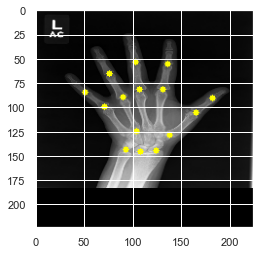

img_name detect_test_img1_L


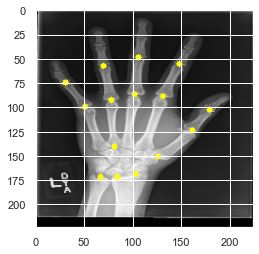

img_name detect_test_img2_L


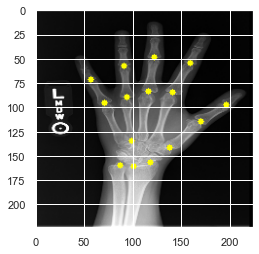

100%|██████████| 1/1 [00:05<00:00,  5.02s/it]

img_name detect_test_img3_L


100%|██████████| 1/1 [00:05<00:00,  5.67s/it]


In [12]:
def main():
    config = vars(parse_args())
    config2 = vars(parse_args2())

    with open('models/%s/config.yml' % config2['name'], 'r') as f:
        config = yaml.load(f, Loader=yaml.FullLoader)

    print('-'*20)
    for key in config.keys():
        print('%s: %s' % (key, str(config[key])))
    print('-'*20)

    cudnn.benchmark = True

    # create model
    print("=> creating model %s" % config['arch'])
    model = archs.__dict__[config['arch']](config['num_classes'],config['input_channels'])
    model = model.cuda()
    
    model.load_state_dict(torch.load('models/%s/model.pth' % config2['name']))
    model.eval()    
    
    #load external dataset
    if config2["data_type"] == "test":
        img_list=[]
        for curDir, dirs, files in os.walk(config2['img_path'] + config2['data_dir']):
            for i, file in enumerate(files):
                if file.endswith(config2['img_ext']):
                    file = file[:-4]
                    img_list.append(os.path.join(curDir + "/" + file + config2['img_ext']))
        
        test_img_ids = [os.path.splitext(os.path.basename(p))[0] for p in img_list]
        test_loader = make_loader_test_only(test_img_ids, config, config2)
        test(config, config2, test_loader, model)
        
    #load validation data set and calculate stratified SDR    
    elif config2["data_type"] == "validation":
        img_ids = glob(os.path.join(config2['img_path'] + config['dataset'] + "/"+ 'images' +"/"+ '*' + config['img_ext']))
        img_ids = [os.path.splitext(os.path.basename(p))[0] for p in img_ids]
        train_img_ids, val_img_ids = train_test_split(img_ids, test_size=0.3, random_state=1)    
        train_loader, val_loader = make_loader(train_img_ids, val_img_ids, config)
        val_sdr_stratified(config, config2, val_loader, model)

if __name__ == '__main__':
    main()

# image crop

In [13]:
def main():
    config = vars(parse_args())
    config2 = vars(parse_args2())
    coord_df = pd.read_csv(config2['img_path'] + config2['data_dir'] + "/" + "coord_final.csv")

    #make dir for each joint
    dir_list = ['finger', 'ulna_radi', 'luna_navi', 'mc_mul', 'racam', 'cmc']
    for dir_name in dir_list:
        os.makedirs(config2['img_path'] + config2['data_dir'] + "/" + dir_name, exist_ok=True)

    for i in range (len(coord_df)):
        img = cv2.imread(config2['img_path'] + config2['data_dir'] + "/" + coord_df.iloc[i,0])
        finger(config, config2, coord_df,img,i)
        mc_mul_cmc(config, config2, coord_df,img,i)
        ulna_radi_luna_navi_racam(config, config2, coord_df,img,i)
if __name__ == '__main__':
    main()

# make Angle of ulnar deviation and Ratio of 4th metacarpal to carpal bone

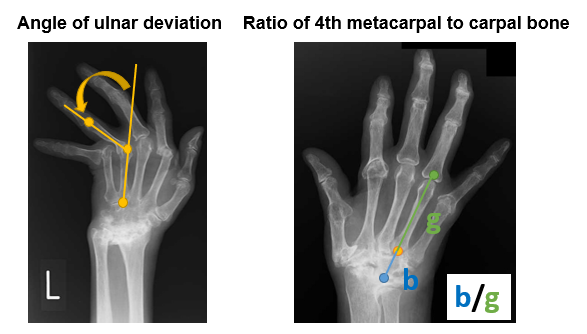

C:\Users\anaconda3\envs\pytorch\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


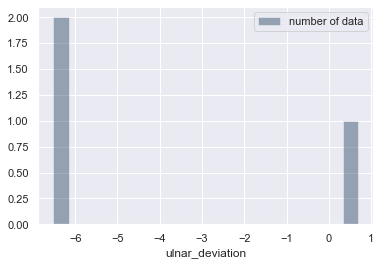

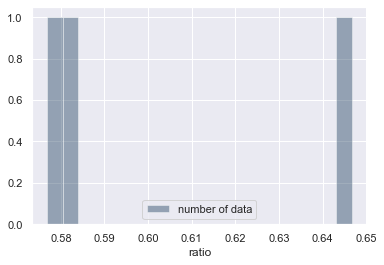

                   img_id       rad     ratio
0  detect_test_img1_L.png -6.512492  0.583244
1  detect_test_img2_L.png -6.514426  0.646676
2  detect_test_img3_L.png  0.685197  0.576892


In [14]:
def main():
    config = vars(parse_args())
    config2 = vars(parse_args2())
    df = pd.read_csv(config2['img_path'] + config2['data_dir'] + "/" + "coord_final.csv")
    df_img = df.iloc[0:,0]
    dfx= df.iloc[0: ,1:16]
    dfy= df.iloc[0: ,16:31]
    
    #Discriminating between right and left hand
    orientation = RLdiscrim(df_img)
        
    #Restore from resized coordinates to original coordinates
    ptarray_x, ptarray_y = coord_reconst(config, config2, dfx, dfy)
    
    #Calculate angle of ulnar deviation
    degree = calc_angle(ptarray_x, ptarray_y, orientation)
    
    #Calculate ratio of metacaropal to carpal bone
    ratio = calc_ratio(ptarray_x, ptarray_y)
    
    rad_ratio_df = pd.concat([df_img, degree, ratio],axis=1)
    print(rad_ratio_df)
    rad_ratio_df.to_csv(config2['img_path'] + config2['data_dir'] + "/" + "rad_ratio_df.csv", index=False)
if __name__ == '__main__':
    main()